# Time Series Analysis Testing

In [1]:
import matplotlib
matplotlib.use('module://ipympl.backend_nbagg')
import hilltoppy
import hydro_processing_tools.data_acquisition as data_acquisition
import hydro_processing_tools.utilities as utilities
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import adfuller

In [2]:
base_url = "http://hilltopdev.horizons.govt.nz/"
hts = "RawLoggerNet.hts"
site = "Manawatu at Foxton"
measurement = "Atmospheric Pressure"
from_date = None
to_date = None
parameters=True
quality_codes=True
dtl_method="trend"

In [3]:
data = data_acquisition.get_data(
    base_url,
    hts,
    site,
    measurement,
    from_date,
    to_date,
    dtl_method,
).set_index("Time")
data.index = pd.to_datetime(data.index)
data = data.asfreq('15T')

display(data.index)
display(data.info())

DatetimeIndex(['2015-04-24 20:45:00', '2015-04-24 21:00:00',
               '2015-04-24 21:15:00', '2015-04-24 21:30:00',
               '2015-04-24 21:45:00', '2015-04-24 22:00:00',
               '2015-04-24 22:15:00', '2015-04-24 22:30:00',
               '2015-04-24 22:45:00', '2015-04-24 23:00:00',
               ...
               '2023-10-13 10:15:00', '2023-10-13 10:30:00',
               '2023-10-13 10:45:00', '2023-10-13 11:00:00',
               '2023-10-13 11:15:00', '2023-10-13 11:30:00',
               '2023-10-13 11:45:00', '2023-10-13 12:00:00',
               '2023-10-13 12:15:00', '2023-10-13 12:30:00'],
              dtype='datetime64[ns]', name='Time', length=296992, freq='15T')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296992 entries, 2015-04-24 20:45:00 to 2023-10-13 12:30:00
Freq: 15T
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SiteName         295919 non-null  object 
 1   MeasurementName  295919 non-null  object 
 2   Value            295919 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.1+ MB


None

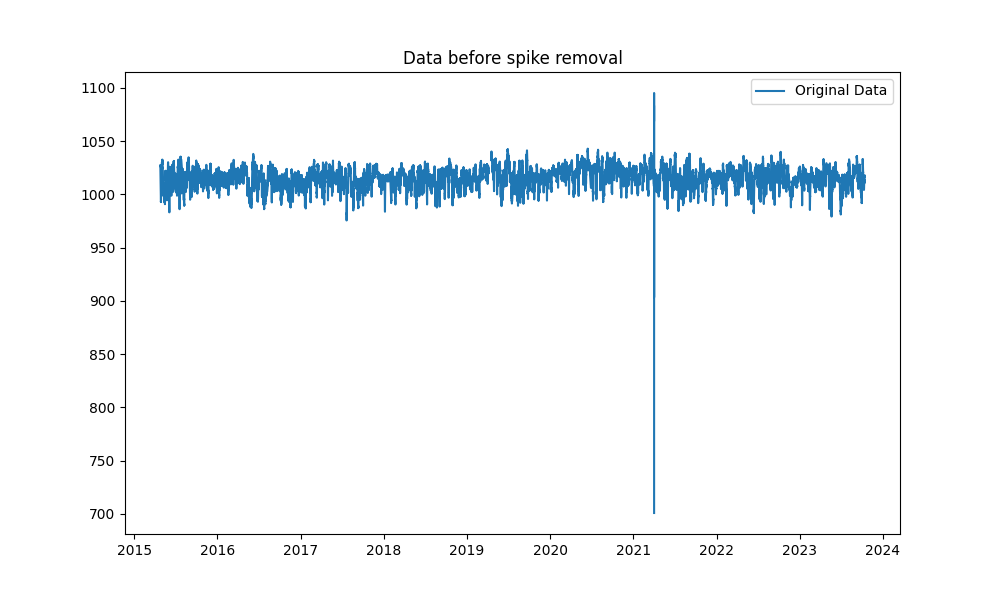

In [4]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.plot(data["Value"], label="Original Data")
plt.title("Data before spike removal")
plt.legend()
plt.show()

In [5]:
data['z_data'] = (data['Value'] - data.Value.rolling(window='365D').mean()) / data.Value.rolling(window='365D').std()
data['zp_data'] = data['z_data'] - data['z_data'].shift(freq='365D')

In [6]:
def plot_rolling(df):
    fig, ax = plt.subplots(3, figsize=(12,9))
    ax[0].plot(df.index, df.Value, label='raw data')
    ax[0].plot(df.Value.rolling(window='365D').mean(), label='rolling mean')
    ax[0].plot(df.Value.rolling(window='365D').std(), label='rolling std (x10)')
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label='de-trended data')
    ax[1].plot(df.z_data.rolling(window='365D').mean(), label='rolling mean')
    ax[1].plot(df.z_data.rolling(window='365D').std(), label='rolling std (x10)')
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label='1Y lag differenced de-trended data')
    ax[2].plot(df.zp_data.rolling(window='365D').mean(), label='rolling mean')
    ax[2].plot(df.zp_data.rolling(window='365D').std(), label='rolling std (x10)')
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

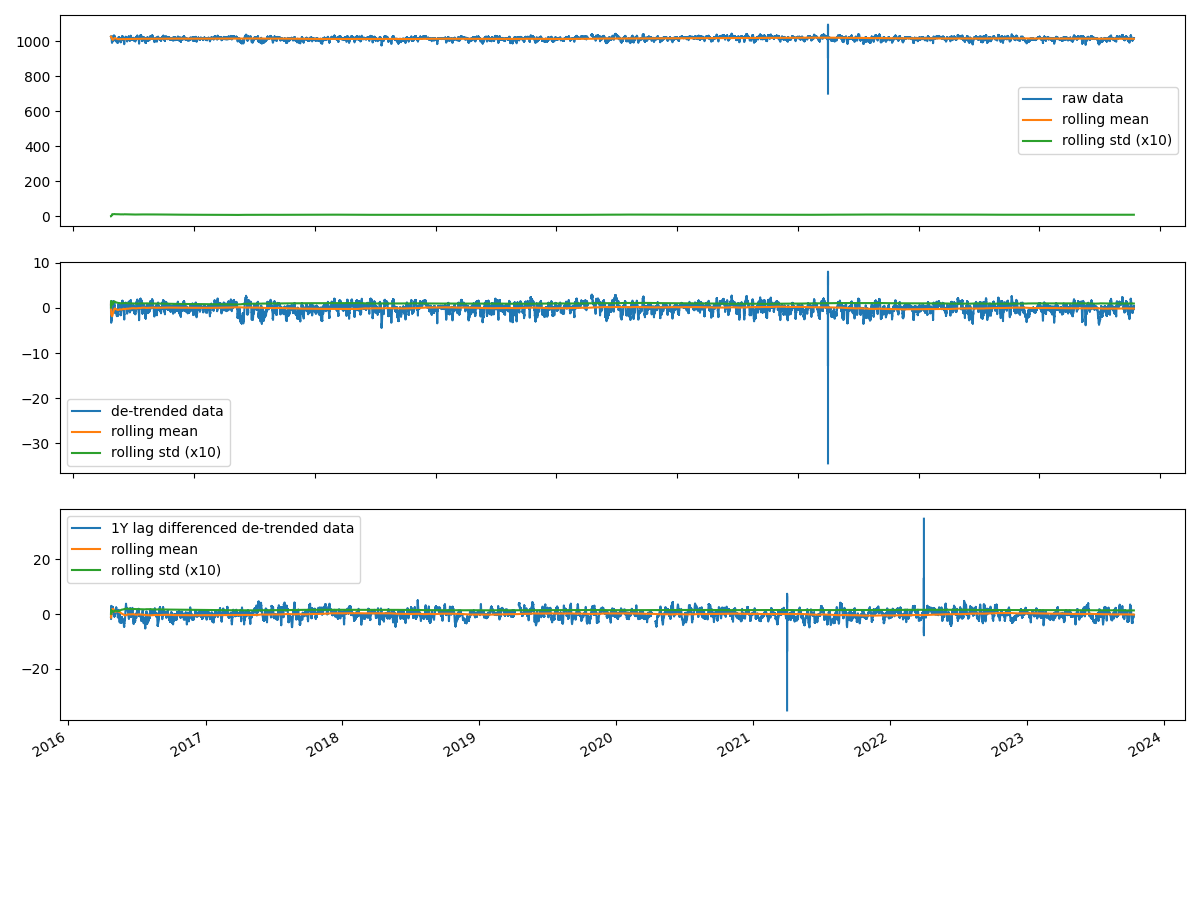

In [7]:
plot_rolling(data)
plt.show()

In [9]:
print(" > Is the data stationary ?")
dftest = adfuller(data.Value, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(data.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(data.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?


MissingDataError: exog contains inf or nans

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296992 entries, 2015-04-24 20:45:00 to 2023-10-13 12:30:00
Freq: 15T
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SiteName         295919 non-null  object 
 1   MeasurementName  295919 non-null  object 
 2   Value            295919 non-null  float64
 3   z_data           295918 non-null  float64
 4   zp_data          259805 non-null  float64
dtypes: float64(3), object(2)
memory usage: 21.7+ MB
